# A. Simple usage
Converting model can be done in simple way.
You need model file (.caffemodel) and some i/o configurations.
In this section, converting Caffenet https://github.com/BVLC/caffe/tree/master/models/bvlc_reference_caffenet is illustrated.

In [1]:
# Download model (skipped if already exists)
! if ! [ -f data/bvlc_reference_caffenet.caffemodel ]; then wget http://dl.caffe.berkeleyvision.org/bvlc_reference_caffenet.caffemodel -P data ; fi

--2017-05-15 17:12:25--  http://dl.caffe.berkeleyvision.org/bvlc_reference_caffenet.caffemodel
Resolving dl.caffe.berkeleyvision.org... 169.229.222.251
Connecting to dl.caffe.berkeleyvision.org|169.229.222.251|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 243862418 (233M) [application/octet-stream]
Saving to: ‘data/bvlc_reference_caffenet.caffemodel’

bvlc_reference_caff 100%[===================>] 232.56M   790KB/s    in 4m 27s  

2017-05-15 17:16:53 (891 KB/s) - ‘data/bvlc_reference_caffenet.caffemodel’ saved [243862418/243862418]



In [2]:
# check if python command (version 3.6+), em++ comamnd, python2 command exists (see setup document)
! python --version
! em++ --version
! python2 --version

Python 3.6.0
emcc (Emscripten gcc/clang-like replacement) 1.37.10 (commit 79697257a5378666a9fa0e7215de1e61673dfe8d)
Copyright (C) 2014 the Emscripten authors (see AUTHORS.txt)
This is free and open source software under the MIT license.
There is NO warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
  
Python 2.7.6


Converting model
You have to specify these model parameters (which can be found in deploy.prototxt):
- Input blob name and shape
- Output blob names (can be comma-separated multiple items)

In [3]:
!python ../../bin/convert_caffe.py --input_name data --input_shape '(1,3,227,227)' --output_names fc8 --out output data/bvlc_reference_caffenet.caffemodel

Loading caffe model... (usually takes several minutes)
Generating feedforward graph
Generating descriptors


You can find model files for WebDNN in `output` directory. Now you can move to application development on web browsers.
Browser side example is `descriptor_run_caffenet.html`.

# B. Using example input
For debugging purpose, you may want to compare output of original model and converted model.
To achieve this, you can manually create input array for the model and get the output array.
Actually, if you simply specify input shape to the command, an array filled with zero is used instead.

In [4]:
# Download model (skipped if already exists)
! if ! [ -f data/bvlc_reference_caffenet.caffemodel ]; then wget http://dl.caffe.berkeleyvision.org/bvlc_reference_caffenet.caffemodel -P data ; fi

## Preparing input array
This is specific to Caffenet, but may be applied to another image processing applications.

In [5]:
# fetching image
from PIL import Image
import urllib.request
import io
import numpy as np

url = "https://upload.wikimedia.org/wikipedia/commons/3/3b/1%2C0_KoShamo.jpg"
img_jpg_data = urllib.request.urlopen(url).read()
with open("data/cock.jpg", "wb") as f:
    f.write(img_jpg_data)
file = io.BytesIO(img_jpg_data)
img = Image.open(file)

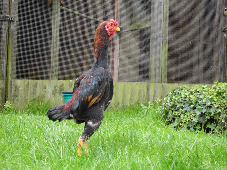

In [6]:
img

In [10]:
# preprocess image
img_resized = img.resize((227, 227))
img_array = np.asarray(img_resized).astype(np.float32, copy=True)
img_array = img_array[:, :, ::-1]  # color to BGR order
img_array -= [103.939, 116.779, 123.68]  # subtract dataset mean for each channel
img_array = np.transpose(img_array, (2, 0, 1))  # data order to channel, height, width
img_array = img_array[np.newaxis, :, :, :]  # sample, channel, height, width
img_array.shape

(1, 3, 227, 227)

In [11]:
np.save("data/cock.npy", img_array)

## Convert model with example input
You can specify numpy array file instead of shape information.
Converted model itself is same.

In [12]:
!python ../../bin/convert_caffe.py --input_name data --input_npy data/cock.npy --output_names fc8 --out output data/bvlc_reference_caffenet.caffemodel

Loading caffe model... (usually takes several minutes)
Generating feedforward graph
Generating descriptors


## Observing output
The output array corresponding to example input is saved.

In [13]:
dnn_output = np.load("output/example_output.npz")  # read output of DNN given input array
fc8 = dnn_output["fc8"]
fc8[0, :10]  # prediction scores for each label

array([ -0.93653762,   1.90181601,  -2.66589904,  -4.17079878,
        -3.09687972,  -4.18737078,  -3.04741526,  12.88711834,
        11.54424572,   6.29262066], dtype=float32)

In [14]:
np.argsort(-fc8[0, :])[:5]  # display top5 label numbers

array([  7,   8, 136,  84,  93])

Human-readable label meanings:
https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a#file-imagenet1000_clsid_to_human-txt

It says 7=cock, 8=hen. Does it match model's prediction?